# IED Detection

This notebook detects IEDs to produce labels for our forecasting algorithms. This includes:
* Loading an EDF file containing the recordings and keeping a defined subset of all channels.
* Running an IED detection algorithm.
* Splitting the data up into different 'windows' which are then labelled with the number of IEDs that occur in the next window.
* Saving these windows and their labels (X.npy/y.npy).

In [1]:
import mne
import scipy
import scipy.io
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20, 10)
mne.set_log_level('WARNING')

Open the file containing the recordings.

In [103]:
raw_fname = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'
# raw_fname = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'

# raw = mne.io.read_raw_edf(raw_fname)
raw = mne.io.read_raw_edf(raw_fname, preload=True)

print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG J12, EEG J11, EEG J10, EEG J9, EEG J8, EEG J7, EEG J6, EEG ...
 chs: 185 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1024.0 Hz
 meas_date: 2020-12-11 14:30:00 UTC
 nchan: 185
 projs: []
 sfreq: 2048.0 Hz
>


Some example code showing how to crop the data, plot Power Spectral Density (PSD), filter, etc.

Reference data and plot for a subset of the channels.

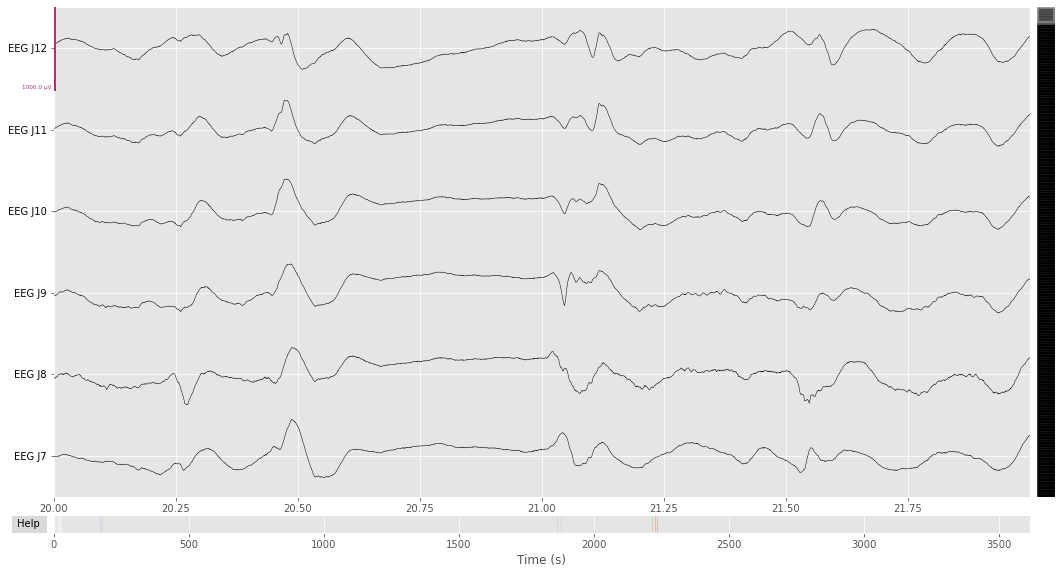

In [104]:
# Optionally crop the data (for debugging purposes)
# plt.rcParams['figure.figsize'] = (6, 8)
# raw.crop(0, 600).load_data()

# Set a reference channel in white matter
raw.set_eeg_reference(ref_channels=['EEG L6']) # TODO re-add this

# Plot 10 seconds of data for 12 channels
test = raw.plot(start=20, duration=2, n_channels=6, scalings=dict(eeg=5e-4))

test.savefig('test.pdf')

Reference the data and exclude noisy channels.

In [105]:
# Load file containing suitable channels and convert to list
mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

# If we don't have a file, we can use channels that contain the word 'EEG'
# valid_channels = [s for s in raw.info.ch_names if "EEG" in s]

# Extract the data from these channels
# raw.set_eeg_reference(ref_channels=[s for s in raw.info.ch_names if "EEG J" in s]) # TODO remove this
Data = raw.get_data(picks=valid_channels)
# Data = raw[valid_channels][0]

# Optionally exclude data with means outside of pre-defined range
# Data = Data[np.where(Data.mean(axis=1) < 1e-05)] # Exclude data with high means (noisy?)

Load the IED detection file which contains a function called DetectSpikes.

In [106]:
%run DetectSpike_SEEG.py

Detect IEDs.

In [107]:
# SpikeIndex contains indices of spikes, ChanId has their channel indices.
SpikeIndex, ChanId, SpikeFV = DetectSpikes(Data, 2048, DetThresholds=[7, 7, 300, 10, 10])
# SpikeIndex, ChanId, SpikeFV = DetectSpikes(mne.filter.resample(Data, down=4, npad='auto'), 512, DetThresholds=[7, 7, 300, 10, 10])

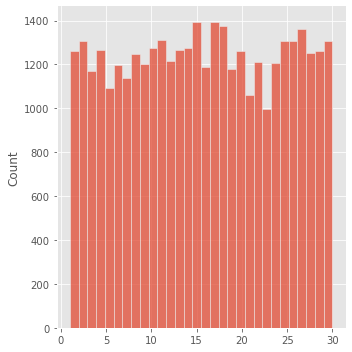

In [108]:
bins = np.arange(0, 3600, 120)
dig = np.digitize(SpikeIndex / 2048, bins)
sns.displot(dig, bins=len(bins))

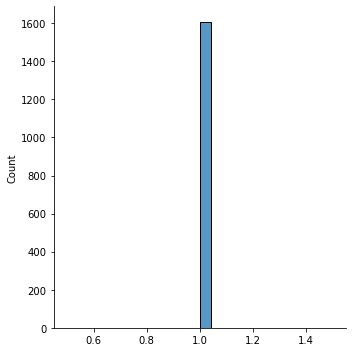

In [57]:
#run on latest
bins = np.arange(0, 3600, 150)
dig = np.digitize(SpikeIndex / 2048, bins)
sns.displot(dig, bins=len(bins))

Plot some data and detected IEDs.

In [120]:
from scipy import stats

stats.mode(ChanId)

ModeResult(mode=array([41]), count=array([2061]))

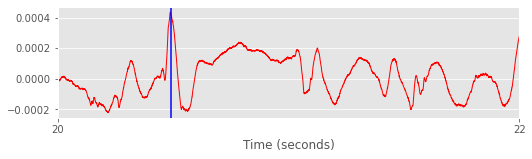

In [171]:
# How many seconds from the start of the recording to consider
seconds = 2
start = 20

plt.rcParams['figure.figsize'] = (7.5, 4)
plt.style.use('ggplot')
# Index of channel to consider
chan = 6

t = np.linspace(start, start+seconds, seconds*2048)

# Plot recording
plt.subplot(212)
plt.xlabel('Time (seconds)')
plt.xlim([start, start+seconds])
plt.plot(t, Data[chan, start*2048:(start+seconds)*2048], color = 'r', linewidth=1)
plt.xticks(np.arange(start, start+seconds + 1, 2))

spike_indices = np.logical_and(ChanId == chan, SpikeIndex < (start+seconds)*2048)
spike_indices = np.logical_and(spike_indices, SpikeIndex > start*2048)
for i, spike in enumerate(SpikeIndex[spike_indices]):
    plt.axvline((spike)/2048, color='b')
    
# plt.legend()
plt.tight_layout()
plt.savefig('IEDs.pdf')

Plot distribution of inter-IED intervals.

Text(0.5, 6.79999999999999, 'Time (s)')

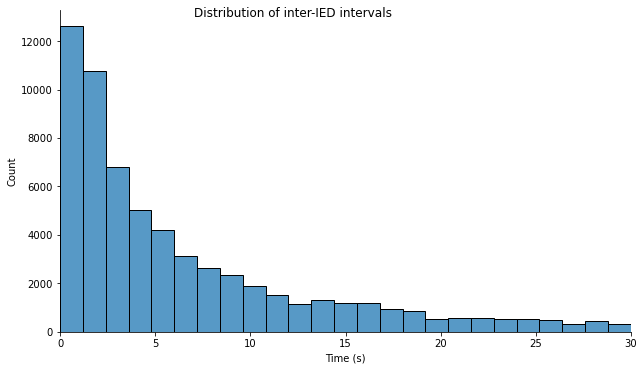

In [12]:
# Difference in time between IEDs
diffs = np.zeros((1))
for channel in np.unique(ChanId):
    diffs = np.append(diffs, np.diff(SpikeIndex[ChanId == channel]))

diffs = diffs[1:]

# Only keep intervals < 30s
filtered_diffs = diffs[diffs / 2048 < 30]

# Plot using histogram
g = sns.displot(filtered_diffs/2048, bins=25)

# Alternatively use kde plot
# g = sns.displot(filtered_diffs/2048, kind='kde')

g.fig.set_size_inches(10,5)
g.set(xlim=(0, 30))
g.fig.suptitle('Distribution of inter-IED intervals')
plt.xlabel('Time (s)')

Create our dataset from the labels.

In [13]:
# In Hz
freq = 2048

# How long (in seconds) our windows are
window_seconds = 1 # todo change back to 10?

X = []
y = []

for channel, to_split in enumerate(Data[:12]):
    
    # number of windows
    windows = math.floor(to_split.shape[0] / (freq*window_seconds))

    # crop data and reshape to windowed dimension
    new_data = to_split[:freq*window_seconds*windows].reshape((windows, freq*window_seconds))

    # get rid of last X window 
    new_data = new_data[:-1]

    labels = np.zeros(windows)

    for spike in SpikeIndex[ChanId == channel]:
        labels[int(spike // (freq*window_seconds))] += 1

    # get rid of first label
    labels = labels[1:]
    
    # Multiplying by 1e5 and converting to float16 to save space
#     X.append((1e5 * new_data).astype(np.float16))
#     X.append(new_data.astype(np.float16))
    X.append(new_data)
    y.append(labels)
    
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

Save as X.npy and y.npy

In [14]:
with open('X.npy', 'wb') as f:
    np.save(f, X)
    
with open('y.npy', 'wb') as f:
    np.save(f, y)

In [16]:
test = []
for i in range(5):
    test.append(X[y>=i].mean())
    
plt.plot(test)

y.mean()

0.1211218836565097